# Kolmogorov-Smirnov Test

## Imports

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, roc_auc_score


## Functions

In [4]:
def cdf(sample, x, sort = False):
    '''
    Return the value of the Cumulative Distribution Function, evaluated for a given sample and a value x.
    
    Args:
        sample: The list or array of observations.
        x: The value for which the numerical cdf is evaluated.
    
    Returns:
        cdf = CDF_{sample}(x)
    '''
    
    # Sorts the sample, if needed
    if sort:
        sample.sort()
    
    # Counts how many observations are below x
    cdf = sum(sample <= x)
    
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    
    return cdf

## Classification evaluation with KS test

### Create synthetic dataset

In [5]:
from sklearn.model_selection import train_test_split

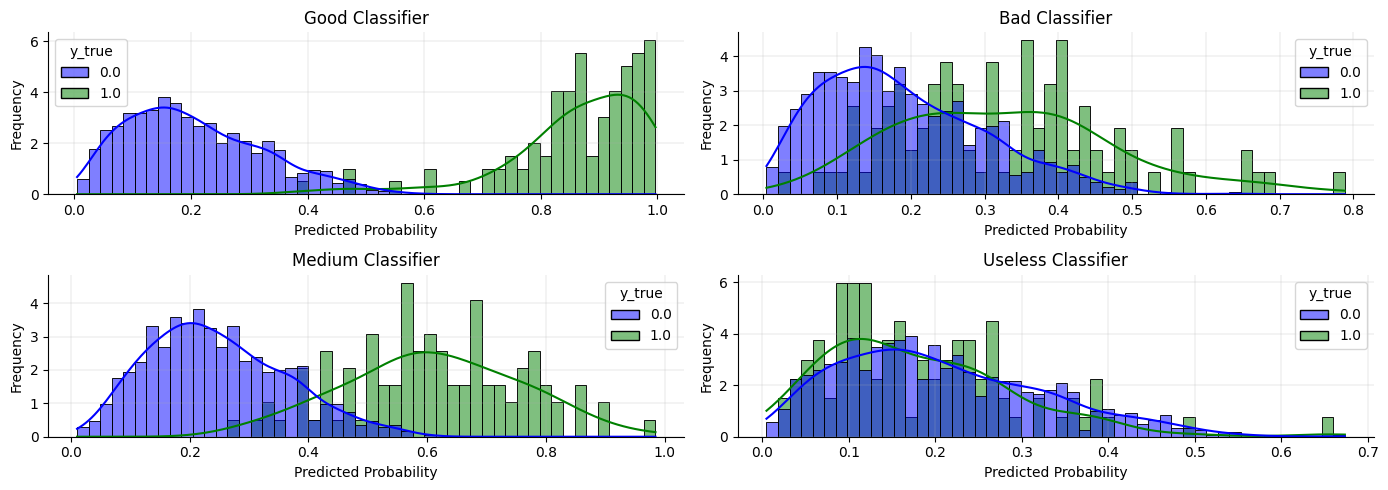

In [137]:
# simulate a true label from fraud detection problem inbalanced
np.random.seed(42)
n = 1000
n_fraud = 100

y = np.zeros(n)
y[:n_fraud] = 1


# simulate a got score prediction score in 0,1. simulating a classification close to 0 from n_fraud -1 and close to 1 from n_fraud to n

y_score_1 = np.random.beta(5, 1, n_fraud)
y_score_0 = np.random.beta(2, 8, n - n_fraud)
y_score = np.concatenate([y_score_1, y_score_0])
df_good_classifier= pd.DataFrame({'y_true': y, 'score': y_score})

def simulate_assimetric_classifier(size_sample: int, n_fraud: int, alpha0: int, beta0: int, alpha1: int, beta1: int):
    np.random.seed(42)
    y = np.zeros(size_sample)
    y[:n_fraud] = 1
    y_score_1 = np.random.beta(alpha1, beta1, n_fraud)
    y_score_0 = np.random.beta(alpha0, beta0, size_sample - n_fraud)
    y_score = np.concatenate([y_score_1, y_score_0])
    df = pd.DataFrame({'y_true': y, 'score': y_score})
    return df

df_good_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=2, beta0=8, alpha1=5, beta1=1)
df_bad_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=2, beta0=9, alpha1=3, beta1=6)
df_medium_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=3, beta0=9, alpha1=5, beta1=3)
df_useless_classifier = simulate_assimetric_classifier(size_sample=1000, n_fraud=100, alpha0=2, beta0=8, alpha1=2, beta1=8)
def plot_hist(df: pd.DataFrame, title: str, ax: plt.Axes, color0: str = 'b', color1: str = 'g'):
    sns.histplot(data=df, x='score', hue='y_true', kde=True, bins=50, ax=ax, common_norm=False, stat="density", palette={0: color0, 1: color1})
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # turn on y axis grid lines with a transparency and gray color
    ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
    
fig, ax = plt.subplots(2, 2, figsize=(14, 5))
ax1, ax2, ax3, ax4 = ax.flatten()
plot_hist(df_good_classifier, 'Good Classifier', ax1)
plot_hist(df_bad_classifier, 'Bad Classifier', ax2)
plot_hist(df_medium_classifier, 'Medium Classifier', ax3)
plot_hist(df_useless_classifier, 'Useless Classifier', ax4)
plt.tight_layout()
plt.show()


## Evaluate KS for  each classifier

In this case we will use the KS to evaluate whether the distributions of the classes are identical or not

The higher the KS statistic, the better.

In [138]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

In [139]:
def evaluate_ks_and_roc_auc(df: pd.DataFrame, proba_col: str, true_value_col: str):
    
    # Recover each class
    class0 = df[df[true_value_col] == 0]
    class1 = df[df[true_value_col] == 1]
    
    ks = ks_2samp(class0[proba_col], class1[proba_col])
    roc_auc = roc_auc_score(df[true_value_col] , df[proba_col])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    return ks.statistic, roc_auc

In [140]:
print("Good classifier:")
ks_good, auc_good = evaluate_ks_and_roc_auc(df=df_good_classifier, proba_col='score', true_value_col='y_true')

Good classifier:
KS: 0.9689 (p-value: 4.246e-112)
ROC AUC: 0.9988


In [141]:
print("Medium classifier:")
ks_medium, auc_medium = evaluate_ks_and_roc_auc(df=df_medium_classifier, proba_col='score', true_value_col='y_true')

Medium classifier:
KS: 0.8233 (p-value: 2.863e-65)
ROC AUC: 0.9726


In [142]:
print("Bad classifier:")
ks_bad, auc_bad = evaluate_ks_and_roc_auc(df=df_bad_classifier, proba_col='score', true_value_col='y_true')

Bad classifier:
KS: 0.4189 (p-value: 9.736e-15)
ROC AUC: 0.7763


In [143]:
print("Useless classifier:")
ks_useless, auc_useless = evaluate_ks_and_roc_auc(df=df_useless_classifier, proba_col='score', true_value_col='y_true')

Useless classifier:
KS: 0.1411 (p-value: 5.121e-02)
ROC AUC: 0.4352


In [144]:
# Gets the class CDFs
def get_classes_cdf(df: pd.DataFrame, proba_col: str, true_value_col: str):

    
    # Recover each class
    class0 = df[df[true_value_col] == 0].sort_values(proba_col)
    class1 = df[df[true_value_col] == 1].sort_values(proba_col)
    
    # Calculates the cdfs
    cdf0 = np.array([cdf(class0[proba_col].values, x, sort = False) for x in class0[proba_col].values])
    cdf1 = np.array([cdf(class1[proba_col].values, x, sort = False) for x in class1[proba_col].values])
    
    # Results
    results =  {
        'cdf0': cdf0,
        'cdf1': cdf1,
        'proba0': class0[proba_col].values, 
        'proba1': class1[proba_col].values, 
    }
    
    return results

In [145]:
cdf_bad = get_classes_cdf(df=df_bad_classifier, proba_col='score', true_value_col='y_true')
cdf_medium = get_classes_cdf(df=df_medium_classifier, proba_col='score', true_value_col='y_true')
cdf_good = get_classes_cdf(df=df_good_classifier, proba_col='score', true_value_col='y_true')
cdf_useless = get_classes_cdf(df=df_useless_classifier, proba_col='score', true_value_col='y_true')

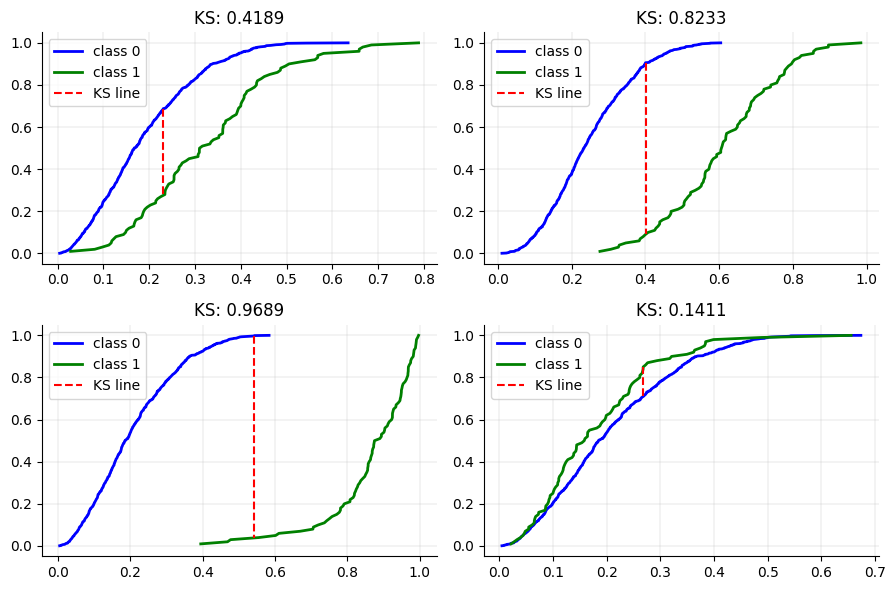

In [146]:


# Função para plotar as CDFs e a linha de KS
def plot_cdf_ks(cdf: dict, ks: float, ax: plt.Axes, color0='b', color1='g'):
    # Plotando as CDFs
    ax.plot(cdf['proba0'], cdf['cdf0'], color='b', linewidth=2)
    ax.plot(cdf['proba1'], cdf['cdf1'], color='g', linewidth=2)

    # Interpolando para garantir que tenham o mesmo número de pontos
    interp_cdf1 = interp1d(cdf['proba1'], cdf['cdf1'], kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Valores interpolados de 'cdf1' na grade de 'proba0'
    cdf1_interp = interp_cdf1(cdf['proba0'])
    
    # Encontrando o ponto de KS (onde a diferença é máxima)
    ks_x = cdf['proba0'][abs(cdf['cdf0'] - cdf1_interp).argmax()]
    ks_y0 = cdf['cdf0'][abs(cdf['cdf0'] - cdf1_interp).argmax()]
    ks_y1 = cdf1_interp[abs(cdf['cdf0'] - cdf1_interp).argmax()]

    # Desenhando a linha vertical no ponto de KS
    ax.vlines(x=ks_x, ymin=ks_y0, ymax=ks_y1, color='r', linestyle='--', label=f'KS = {ks:.4f}')
    
    # Configurando a legenda e o título
    ax.legend(["class 0", "class 1", f"KS line"])
    ax.set_title(f"KS: {ks:.4f}")
    
    # Ajustando a estética
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.2)


fig, ax = plt.subplots(2, 2, figsize=(9, 6))
ax1, ax2, ax3, ax4 = ax.flatten()
plot_cdf_ks(cdf_bad, ks_bad, ax1)
plot_cdf_ks(cdf_medium, ks_medium, ax2)
plot_cdf_ks(cdf_good, ks_good, ax3)
plot_cdf_ks(cdf_useless, ks_useless, ax4)
plt.tight_layout()
plt.show()


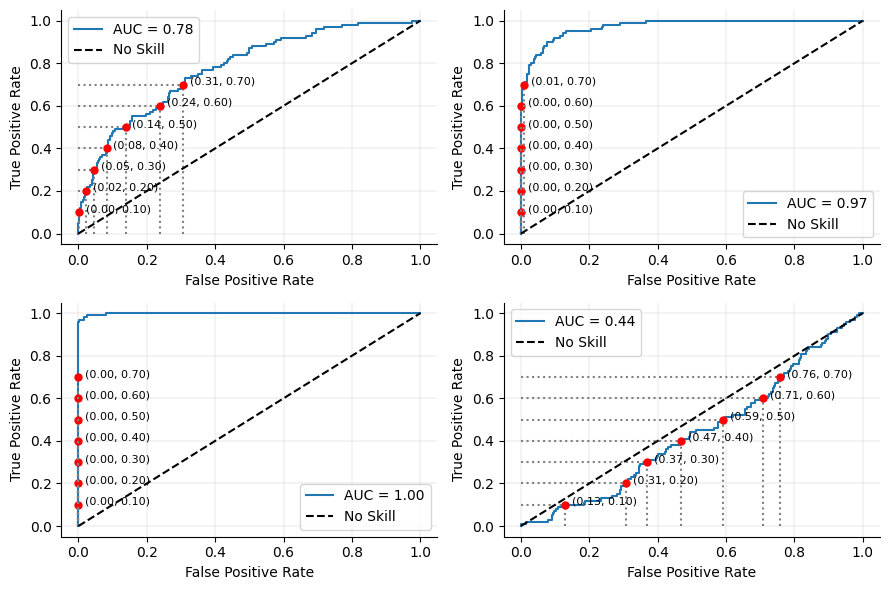

In [158]:
def plot_roc_curve(df: pd.DataFrame, proba_col: str, true_value_col: str, ax: plt.Axes):
    # Pegando as colunas de probabilidade e os valores verdadeiros
    y_true = df[true_value_col]
    y_pred_proba = df[proba_col]
    
    # Calculando a curva ROC e a AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    # Plotando a curva ROC
    ax.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    
    # Adicionar a marcação dos pontos 10%, 20%, 30%, ..., 70% de True Positive Rate
    marcacoes_tpr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

    # Para cada TPR, encontrar o ponto correspondente na curva
    for tpr_value in marcacoes_tpr:
        # Encontrar o índice do ponto mais próximo da TPR desejada
        closest_index = np.argmin(np.abs(tpr - tpr_value))
        fpr_value = fpr[closest_index]
        
        # Adicionar linhas pontilhadas
        ax.plot([fpr_value, fpr_value], [0, tpr_value], linestyle=':', color='gray')  # linha vertical
        ax.plot([0, fpr_value], [tpr_value, tpr_value], linestyle=':', color='gray')  # linha horizontal
        
        # Plotar o ponto com marcador tamanho 5
        ax.plot(fpr_value, tpr_value, 'ro', markersize=5)
        
        # Adicionar o texto com as coordenadas ao lado do ponto
        ax.text(fpr_value + 0.02, tpr_value, f'({fpr_value:.2f}, {tpr_value:.2f})', fontsize=8, color='black')
    
    # Adicionar a linha "No Skill" (classificador aleatório)
    ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill', color='black')
    
    # Configurar rótulos e a legenda
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    # Ajustando a estética
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
    ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
    
fig, ax = plt.subplots(2, 2, figsize=(9, 6))
ax1, ax2, ax3, ax4 = ax.flatten()
plot_roc_curve(df_bad_classifier, 'score', 'y_true', ax1)
plot_roc_curve(df_medium_classifier, 'score', 'y_true', ax2)
plot_roc_curve(df_good_classifier, 'score', 'y_true', ax3)
plot_roc_curve(df_useless_classifier, 'score', 'y_true', ax4)
plt.tight_layout()
plt.show()

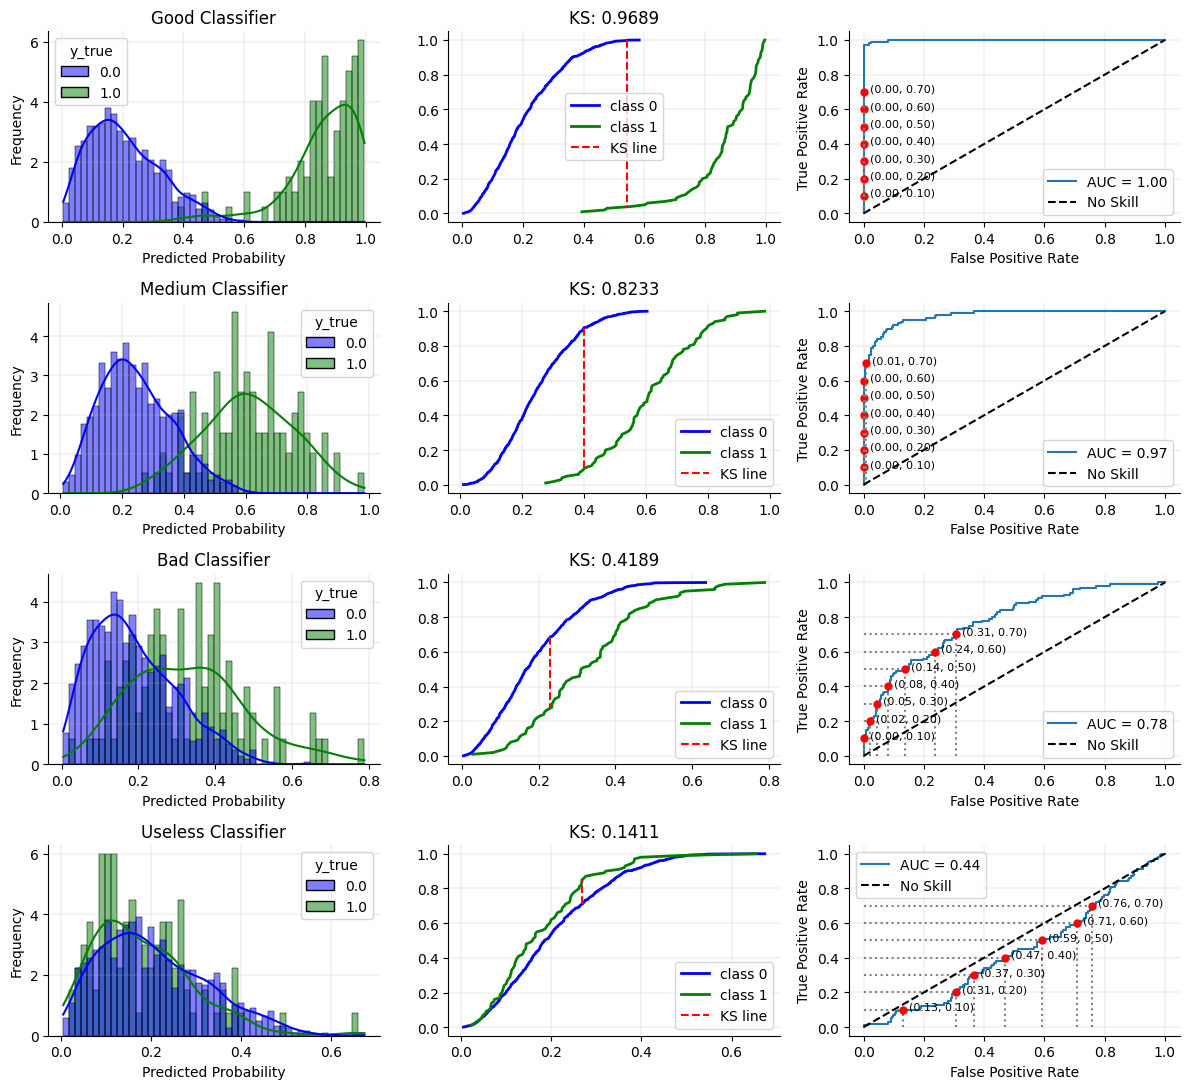

In [159]:
# plot cada distribuição de probabilidade a esquerda e sua cdf a direita com a linha de ks
fig, ax = plt.subplots(4, 3, figsize=(12, 11))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = ax.flatten()

# Good classifier
plot_hist(df_good_classifier, 'Good Classifier', ax1, color0='b', color1='g')
plot_cdf_ks(cdf_good, ks_good, ax2, color0='b', color1='g')
plot_roc_curve(df_good_classifier, 'score', 'y_true', ax3)

# Medium classifier
plot_hist(df_medium_classifier, 'Medium Classifier', ax4, color0='b', color1='g')
plot_cdf_ks(cdf_medium, ks_medium, ax5, color0='b', color1='g')
plot_roc_curve(df_medium_classifier, 'score', 'y_true', ax6)

# Bad classifier
plot_hist(df_bad_classifier, 'Bad Classifier', ax7, color0='b', color1='g')
plot_cdf_ks(cdf_bad, ks_bad, ax8, color0='b', color1='g')
plot_roc_curve(df_bad_classifier, 'score', 'y_true', ax9)

# Useless classifier
plot_hist(df_useless_classifier, 'Useless Classifier', ax10, color0='b', color1='g')
plot_cdf_ks(cdf_useless, ks_useless, ax11, color0='b', color1='g')
plot_roc_curve(df_useless_classifier, 'score', 'y_true', ax12)

plt.tight_layout()
plt.show()


